In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import geopandas as gpd
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import ttest_ind
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM

### Load and format CBP/CMC Data

In [2]:
df = pd.read_csv('Source Data/Water_Final.csv', dtype = 'str')

In [3]:
df['YEAR'] = pd.DatetimeIndex(df['Date']).year

df['MeasureValue'] = df['MeasureValue'].astype('float64')

df.loc[(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['MeasureValue'] > 30), 'MeasureValue'] = df.loc[(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['MeasureValue'] > 30), 'MeasureValue'] / 100

year_agg = df.loc[(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin([2015, 2016, 2017, 2018, 2019])), ['YEAR', 'HUC12_', 'MeasureValue']].pivot_table(index = 'HUC12_', columns = 'YEAR', aggfunc = 'mean').dropna().reset_index()

year_agg.columns = year_agg.columns.droplevel()

year_agg.columns = ['HUC12_', 2015, 2016, 2017, 2018, 2019]

year_agg['Change'] = np.abs(year_agg[2019] - year_agg[2015])

In [4]:
df['ParameterName_CBP'].value_counts()

WATER TEMPERATURE DEG                                               430638
DISSOLVED OXYGEN IN MG/L                                            423900
PH CORRECTED FOR TEMPERATURE (25 DEG C)                             411264
SALINITY UNITS IN PPT AND EQUAL TO PRACTICAL SALNITY UNITS (PSU)    371427
TOTAL SUSPENDED SOLIDS                                              128083
ORTHOPHOSPHATE PHOSPHORUS AS P (FILTERED SAMPLE)                    122577
NITRATE NITROGEN AS N (FILTERED SAMPLE)                             121419
TOTAL PHOSPHORUS                                                    114674
TOTAL NITROGEN                                                      112110
AMMONIUM NITROGEN AS N (FILTERED SAMPLE)                            111958
ACTIVE CHLOROPHYLL-A                                                 99820
SECCHI DEPTH                                                         56980
TURBIDITY; NEPHELOMETRIC METHOD                                      43796
Not in CBP Database      

### Find Extreme Changes

In [5]:
pd.merge(left = year_agg.sort_values(by = 'Change', ascending = False).head(10),
         right = df[['HUC12_', 'HUCNAME_', 'STATE_', 'COUNTY_']].drop_duplicates(),
         on = 'HUC12_',
         how = 'left')

,HUC12_,2015,2016,2017,2018,2019,Change,HUCNAME_,STATE_,COUNTY_
0,020700050702,4.527778,5.833333,6.535714,6.692308,6.979167,2.451389,Canada Run-South River,VA,Augusta County
1,020503061106,7.123571,7.506729,6.033723,5.972857,5.956410,1.167161,Muddy Run-Mill Creek,PA,Lancaster County
2,020503061709,8.350000,8.165278,7.660704,7.497045,7.306957,1.043043,Fishing Creek-Susquehanna River,PA,Lancaster County
3,020503060903,8.066667,8.107692,8.881818,9.080000,9.018182,0.951515,Hammer Creek,PA,Lancaster County
4,020501050405,8.150000,8.125000,7.500000,7.166667,7.250000,0.900000,Hendy Creek-Chemung River,NY,Chemung County
5,020503010802,8.125000,8.009333,7.488750,6.893158,7.340769,0.784231,Lower Mahantango Creek,PA,Dauphin County
6,020503060901,8.341667,8.341667,9.190909,9.178000,9.085000,0.743333,Little Cocalico Creek-Cocalico Creek,PA,Lancaster County
7,020700050103,5.333333,5.800000,5.906250,5.333333,6.041667,0.708333,Jennings Branch,VA,Augusta County
8,020700100102,7.558333,7.718182,7.608333,7.360000,6.906509,0.651824,Lower Rock Creek,DC,District of Columbia
9,020700100102,7.558333,7.718182,7.608333,7.360000,6.906509,0.651824,Lower Rock Creek,MD,Montgomery County


### Watershed Shapefiles

In [6]:
huc_8 = gpd.read_file("Source Data/WBD_National_GDB.gdb", driver='FileGDB', layer='WBDHU8')
huc_12 = gpd.read_file("Source Data/WBD_National_GDB.gdb", driver='FileGDB', layer='WBDHU12')

### Study of South Fork Rapidan-Upper Rappahannock & Middle Potomac-Catoctin Watersheds

In [7]:
def shape12(huc8):
    shape_12 = gpd.GeoDataFrame(pd.merge(
        left = year_agg.loc[year_agg['HUC12_'].str.startswith(huc8)],
        right = huc_12,
        left_on = 'HUC12_',
        right_on = 'HUC12',
        how = 'left'
    ))
    shape_12['Delta'] = shape_12[2019] - shape_12[2015]
    return shape_12

In [8]:
def wsname(code, level_8):
    if level_8:
        return huc_8.loc[huc_8['HUC8'] == code, 'NAME'].values[0]
    else:
        return huc_12.loc[huc_12['HUC12'] == code, 'NAME'].values[0]

In [9]:
upp_rapp = huc_8[huc_8['HUC8'] == '02080103']

upp_rapp_det = shape12('02080103')

In [10]:
def plot_changemap(huc8):
    fig, ax = plt.subplots(1,1, figsize = (15,9))
    plt.title(f'Change in pH, 2015-2019, {wsname(huc8, True)} Watershed')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.03)
    huc_8[huc_8['HUC8'] == huc8].plot(ax = ax, color = 'lightgrey')
    huc_12.loc[huc_12['HUC12'].str.startswith(huc8)].boundary.plot(ax = ax, color = 'k', linewidth = 0.3)
    shape12(huc8).plot(ax = ax, 
                     column = 'Delta', 
                     legend = True, 
                     cmap = 'RdBu', 
                     cax = cax, 
                     vmin = - max(shape12(huc8)['Change']), 
                     vmax = max(shape12(huc8)['Change']))
    ax.axis('off')
    plt.savefig(f'Images/Change_{wsname(huc8, True)}.png', transparent = True)
    plt.close()

In [11]:
def sig_change(huc8):
    changes = {
        'HUC12': [],
        'HUC NAME': [],
        'FROM': [],
        'TO': [],
        'p-value': []
    }
    for huc12 in shape12(huc8)['HUC12_'].unique():
        for year in np.arange(2015, 2019):
            p_value = ttest_ind(
                df.loc[(df['HUC12_'] == huc12) & (df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'] == year), 'MeasureValue'],
                df.loc[(df['HUC12_'] == huc12) & (df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'] == year + 1), 'MeasureValue']
            )[1]
            if p_value < 0.05:
                changes['HUC12'].append(huc12)
                changes['HUC NAME'].append(df.loc[df['HUC12_'] == huc12, 'HUCNAME_'].values[0])
                changes['FROM'].append(year)
                changes['TO'].append(year + 1),
                changes['p-value'].append(p_value)
    changes_df = pd.DataFrame(changes)
    changes_df.sort_values(by = 'p-value', inplace = True)
    return changes_df

In [12]:
def box_years(huc8):
    for huc12 in shape12(huc8)['HUC12_'].unique():
        try:
            plt.boxplot([df.loc[(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['HUC12_'] == huc12) & (df['YEAR'] == year), 'MeasureValue'] for year in (2015, 2016, 2017, 2018, 2019)], labels = (2015, 2016, 2017, 2018, 2019));
            plt.title(f'pH in {wsname(huc12, False)}, 2015-2019')
            plt.savefig(f'Images/{wsname(huc8, True)}_Boxplot_{wsname(huc12, False)}.png', transparent = True)
        except:
            pass
        plt.close()

In [13]:
def map_years(huc8):
    for year in np.arange(2015, 2020):
        fig, ax = plt.subplots(1,1, figsize = (15,9))
        plt.title(f'{year} Mean pH, {wsname(huc8, True)}')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="3%", pad=0.03)
        huc_8[huc_8['HUC8'] == huc8].plot(ax = ax, color = 'lightgrey')
        huc_12.loc[huc_12['HUC12'].str.startswith(huc8)].boundary.plot(ax = ax, color = 'k', linewidth = 0.3)
        shape12(huc8).plot(
            ax = ax, 
            column = year,
            legend = True,
            cmap = 'RdBu',
            cax = cax, 
            vmin = 4,
            vmax = 10
        )
        ax.axis('off')
        plt.savefig(f'Images/{wsname(huc8, True)}_{year}.png', transparent = True)
        plt.close();

In [14]:
def change_hist(huc8):
    fig, ax = plt.subplots(1,1, figsize = (10,7))
    plt.hist(shape12(huc8)['Delta'], bins = 'sqrt')
    plt.title(f'Change in pH, 2015-2019, {wsname(huc8, True)}')
    plt.savefig(f'Images/{wsname(huc8, True)}_change_hist.png', transparent = True)
    plt.close();

In [15]:
def plot_ts(huc8):
    for huc12 in shape12(huc8)['HUC12_'].unique():
        try:
            fig, ax = plt.subplots(1,1, figsize = (10,7))
            plt.title('pH Values, 2015-2019')
            for series, label in zip([year_agg.loc[:,[2015,2016,2017,2018,2019]].mean(), 
                                      year_agg.loc[year_agg['HUC12_'].str.startswith(huc8),[2015,2016,2017,2018,2019]].mean(), 
                                      year_agg.loc[year_agg['HUC12_'] == huc12,[2015,2016,2017,2018,2019]].mean()], 
                                     ['Chesapeake Watershed', 
                                      f'{wsname(huc8, True)} Watershed', 
                                      f'{wsname(huc12, False)} Watershed']):
                series.index = pd.date_range(start='1/1/2015', periods=5, freq = 'Y')
                plt.plot(series, label = label)

            plt.scatter(
                x = pd.DatetimeIndex(df.loc[(df['HUC12_'] ==  huc12) & (df['YEAR'].isin([2015,2016,2017,2018,2019]))& (df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)'), 'Date']),
                y = df.loc[(df['HUC12_'] ==  huc12) & (df['YEAR'].isin([2015,2016,2017,2018,2019]))& (df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)'), 'MeasureValue'],
                alpha = 0.2,
                color = 'tab:green'
            )
            
            plt.legend()
            plt.savefig(f'Images/{wsname(huc8, True)}_Timeseries_{wsname(huc12, False)}.png', transparent = True)
        except:
            pass
        plt.close()

In [16]:
df['HUC8_'] = df['HUC12_'].str[:8]

In [17]:
fig, ax = plt.subplots(1,2, figsize = (15, 7))
ax = ax.ravel()
ax[1].hist(df.loc[(df['YEAR'].isin([2015,2016,2017,2018,2019]))& (df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)'), ['MeasureValue','HUC8_']].groupby('HUC8_').std().reset_index()['MeasureValue'], color = 'k');
ax[0].hist(df.loc[(df['YEAR'].isin([2015,2016,2017,2018,2019]))& (df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)'), ['MeasureValue','HUC8_']].groupby('HUC8_').mean().reset_index()['MeasureValue'], color = 'k');
for huc8, color in zip(['02080103','02070008'], ['lime', 'magenta']):
    ax[1].axvline(df.loc[(df['YEAR'].isin([2015,2016,2017,2018,2019]))& (df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['HUC8_'] == huc8), 'MeasureValue'].std(), label = wsname(huc8, True), color = color)
    ax[0].axvline(df.loc[(df['YEAR'].isin([2015,2016,2017,2018,2019]))& (df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['HUC8_'] == huc8), 'MeasureValue'].mean(), label = wsname(huc8, True), color = color)
for ax, title in zip(ax, ['Mean pH Value, 2015-2019', 'Standard Deviation pH Value, 2015-2019']):
    ax.legend();
    ax.set_title(title)
plt.savefig('Images/Mean-Std-Compare.png', transparent = True)
plt.close();

In [18]:
for huc8 in ['02080103','02070008']:
    plot_changemap(huc8)
    print(wsname(huc8, True))
    print(sig_change(huc8))
    box_years(huc8)
    map_years(huc8)
    change_hist(huc8)
    plot_ts(huc8)

Rapidan-Upper Rappahannock
          HUC12                        HUC NAME  FROM    TO   p-value
1  020801030602  Ruffans Run-Rappahannock River  2017  2018  0.000335
8  020801031002                       Cedar Run  2017  2018  0.002971
4  020801030703       South River-Rapidan River  2018  2019  0.006391
6  020801030906        Great Run-Robinson River  2017  2018  0.006814
7  020801030906        Great Run-Robinson River  2018  2019  0.007431
0  020801030602  Ruffans Run-Rappahannock River  2016  2017  0.009513
3  020801030703       South River-Rapidan River  2017  2018  0.009731
5  020801030906        Great Run-Robinson River  2016  2017  0.010392
2  020801030602  Ruffans Run-Rappahannock River  2018  2019  0.047526
Middle Potomac-Catoctin
          HUC12                   HUC NAME  FROM    TO   p-value
1  020700081005  Nichols Run-Potomac River  2017  2018  0.001526
2  020700081005  Nichols Run-Potomac River  2018  2019  0.002017
0  020700080302             Catoctin Creek  2017  2018

### Hexbin distribution maps

In [19]:
huc_4 = gpd.read_file("Source Data/WBD_National_GDB.gdb", driver='FileGDB', layer='WBDHU4')
chesapeake = gpd.GeoSeries(huc_4[huc_4['HUC4'].isin(['0205', '0206', '0207', '0208'])].unary_union)

In [20]:
df = pd.merge(left = df,
         right = df['Point'].str.replace('POINT \(', '').str.replace('\)', '').str.partition(' ').rename(columns = {0:'Xcoord', 2: 'Ycoord'}).drop(columns = 1),
         how = 'left',
         left_index = True,
         right_index = True)

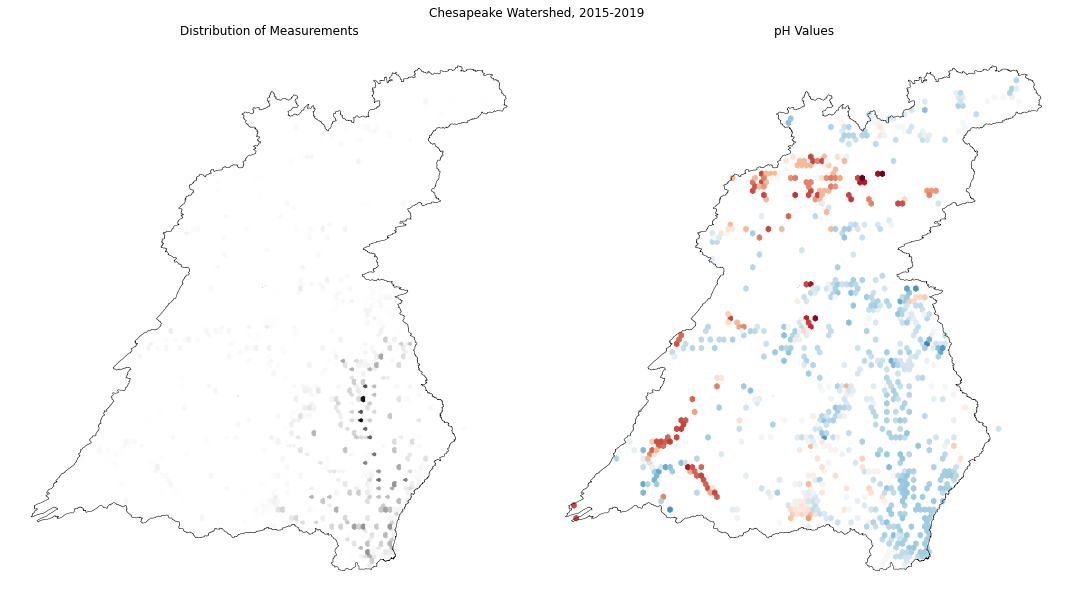

In [21]:
fig, ax = plt.subplots(1,2, figsize = (15,9))
ax = ax.ravel()
ax[1].hexbin(x = df.loc[(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin([2015, 2016, 2017, 2018, 2019])), 'Xcoord'], 
          y = df.loc[(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin([2015, 2016, 2017, 2018, 2019])), 'Ycoord'],
             C  = df.loc[(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin([2015, 2016, 2017, 2018, 2019])), 'MeasureValue'],
          cmap = 'RdBu', vmin = 4, vmax = 10)
ax[0].hexbin(x = df.loc[(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin([2015, 2016, 2017, 2018, 2019])), 'Xcoord'], 
          y = df.loc[(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin([2015, 2016, 2017, 2018, 2019])), 'Ycoord'], 
          cmap = 'binary')
for ax, title in zip(ax, ['Distribution of Measurements', 'pH Values']):
    chesapeake.boundary.plot(ax = ax, color = 'k', linewidth = 0.5)
    ax.set_title(title)
    ax.axis('off')
plt.suptitle("Chesapeake Watershed, 2015-2019")
plt.tight_layout();

In [22]:
def map_dist(huc8):
    fig, ax = plt.subplots(1,2, figsize = (15,9))
    ax = ax.ravel()
    ax[1].hexbin(x = df.loc[(df['HUC12_'].str.startswith(huc8)) & (df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin([2015, 2016, 2017, 2018, 2019])), 'Xcoord'], 
              y = df.loc[(df['HUC12_'].str.startswith(huc8)) &(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin([2015, 2016, 2017, 2018, 2019])), 'Ycoord'],
                 C  = df.loc[(df['HUC12_'].str.startswith(huc8)) &(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin([2015, 2016, 2017, 2018, 2019])), 'MeasureValue'],
              cmap = 'RdBu', vmin = 4, vmax = 10)
    ax[0].hexbin(x = df.loc[(df['HUC12_'].str.startswith(huc8)) &(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin([2015, 2016, 2017, 2018, 2019])), 'Xcoord'], 
              y = df.loc[(df['HUC12_'].str.startswith(huc8)) &(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin([2015, 2016, 2017, 2018, 2019])), 'Ycoord'], 
              cmap = 'binary')
    for ax, title in zip(ax, ['Distribution of Measurements', 'pH Values']):
        huc_8[huc_8['HUC8'] == huc8].boundary.plot(ax = ax, color = 'k', linewidth = 0.5)
        ax.set_title(title)
        ax.axis('off')
    plt.suptitle(f"{wsname(huc8, True)} Watershed, 2015-2019")
    plt.tight_layout()
    plt.savefig(f"Images/{wsname(huc8, True)}_MapDist.png", transparent = True)
    plt.close();

In [23]:
def map_cover(huc8):
    fig, ax = plt.subplots(1,1, figsize = (15,9))
    hb = ax.hexbin(x = df.loc[(df['HUC12_'].str.startswith(huc8)) &(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin([2015, 2016, 2017, 2018, 2019])), 'Xcoord'], 
               y = df.loc[(df['HUC12_'].str.startswith(huc8)) &(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin([2015, 2016, 2017, 2018, 2019])), 'Ycoord'], 
              cmap = 'binary')
    fig.colorbar(hb, ax = ax)
    huc_12[huc_12['HUC12'].isin(year_agg.loc[year_agg['HUC12_'].str.startswith(huc8), 'HUC12_'].unique())].plot(ax = ax, color = 'k', alpha = 0.1)
    huc_8[huc_8['HUC8'] == huc8].boundary.plot(ax = ax, color = 'k', linewidth = 0.5)
    ax.axis('off')
    plt.suptitle(f"{wsname(huc8, True)} Watershed, 2015-2019")
    plt.tight_layout()
    plt.savefig(f"Images/{wsname(huc8, True)}_MapCover.png", transparent = True)
    plt.close();

In [24]:
benthic = pd.read_csv('Source Data/Benthic_Stream_Health.csv', dtype = str)
benthic['YEAR'] = benthic['sample_date'].str[-4:].astype('int')
benthic.rename(columns = {'HUC12': 'HUC12_'}, inplace = True)

In [25]:
def colorcmap(color):
    r, g, b = mcolors.to_rgb(color)
    N = 1000
    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(r, 1, N, 1)
    vals[:, 1] = np.linspace(g, 1, N, 1)
    vals[:, 2] = np.linspace(b, 1, N, 1)
    vals[:, 3] = np.linspace(0, 1, N, 1)[::-1]
    return mcolors.ListedColormap(vals[::-1])

In [26]:
def map_overlap(huc8):
    fig, ax = plt.subplots(1,1, figsize = (15,9))

    huc_8[huc_8['HUC8'] == huc8].boundary.plot(ax = ax, color = 'k', linewidth = 0.5)

    for data, coord, color, label in zip(
        [
            df.loc[(df['HUC12_'].str.startswith(huc8)) &(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin(benthic['YEAR'].unique()))],
            benthic.loc[(benthic['HUC12_'].str.startswith(huc8))]
        ],
        [
            ('Xcoord', 'Ycoord'),
            ('Longitude', 'Latitude')
        ],
        [
            'tab:blue',
            'tab:orange'
        ],
        [
            'Water Quality Data',
            'Benthic Data'
        ]
    ):

        hb = ax.hexbin(x = data[coord[0]], y = data[coord[1]], cmap = colorcmap(color), gridsize = int(data.shape[0] ** 0.5))
        gpd.GeoSeries(huc_12[huc_12['HUC12'].isin(data['HUC12_'].unique())].unary_union).boundary.plot(ax = ax, color = color, linewidth = 0.5, label = label)

    ax.axis('off')
    plt.suptitle(f"{wsname(huc8, True)} Watershed, {benthic['YEAR'].unique()[0]}-{benthic['YEAR'].unique()[-1]}")
    plt.legend(loc =(0, 0.9))
    plt.tight_layout();
    plt.savefig(f"Images/{wsname(huc8, True)}_MapOverlap.png", transparent = True)
    plt.close();

In [27]:
for huc8 in ['02080103','02070008']:
    map_dist(huc8)
    map_cover(huc8)
    map_overlap(huc8)

In [28]:
benthic['rating'] = benthic['rating'].map({'excellent': 4, 'good':3, 'fair':2, 'poor':1, 'very_poor':0})

In [29]:
def scatter_values(dataset, title):
    for aggfunc, aggtitle in zip(['mean', 'std'], ['Mean', 'Standard Deviation']):
        plt.figure(figsize = (9, 7))
        for huc8, color, alpha in zip(['', '02080103','02070008'], ['k', 'tab:cyan', 'tab:orange'], [0.2, 1, 1]):
            try:
                label = wsname(huc8, True)
            except:
                label = 'All'
            plt.scatter(data = pd.merge(
                benthic.groupby('HUC12_')['rating'].mean()[benthic.loc[benthic['HUC12_'].str.startswith(huc8), 'HUC12_'].unique()],
                dataset.groupby('HUC12_')['MeasureValue'].agg(aggfunc)[dataset.loc[dataset['HUC12_'].str.startswith(huc8), 'HUC12_'].unique()],
                left_index = True,
                right_index = True,
                how = 'left'
            ).dropna(), 
                        x = 'MeasureValue', 
                        y = 'rating',
                        s = 50,
                       color = color,
                       alpha = alpha,
                       label = label)
        plt.legend()
        plt.xlabel(f'{aggtitle} {title}')
        plt.ylabel('Mean Benthic Rating')
        plt.title(f'Mean Benthic Rating vs {aggtitle} {title} per HUC8 ')
        plt.savefig(f'Images/Scatter{aggtitle}{title}.png', transparent = True)
        plt.close();

In [30]:
for dataset, title in zip((df.loc[(df['ParameterName_CBP'] == parameter) & (df['YEAR'].isin(benthic['YEAR'].unique()))] for parameter in ['PH CORRECTED FOR TEMPERATURE (25 DEG C)', 'WATER TEMPERATURE DEG']), ['pH', 'Water Temperature']):
    scatter_values(dataset, title)

### Plot Chloropleth over Basemap

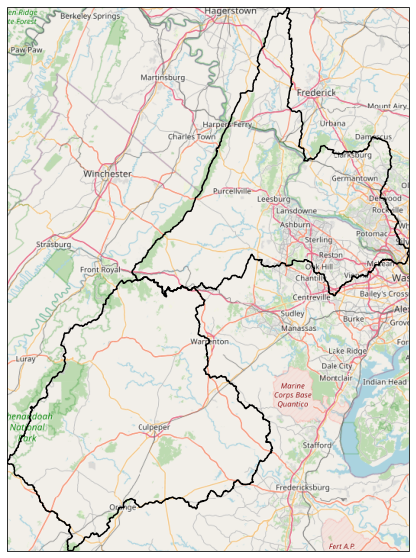

In [31]:
imagery = OSM()
x0, y0, x1, y1 = huc_8.loc[huc_8['HUC8'].isin(['02080103','02070008'])].unary_union.bounds

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())

ax.add_image(imagery, 9)

huc_8.loc[huc_8['HUC8'].isin(['02080103','02070008'])].boundary.plot(ax = ax, color = 'k', transform = ccrs.PlateCarree())

plt.show()

In [32]:
def chloropleth_values(data, parameter, valuecol, huc8, year, cmap, crange):
    imagery = OSM()
    x0, y0, x1, y1 = huc_8.loc[huc_8['HUC8'] == huc8].unary_union.bounds

    fig = plt.figure(figsize = (15, 9))

    ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
    ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())

    ax.add_image(imagery, 9)

    huc_8.loc[huc_8['HUC8'] == huc8].plot(ax = ax, color = 'k', alpha = 0.1, transform = ccrs.PlateCarree())
    huc_8.loc[huc_8['HUC8'] == huc8].boundary.plot(ax = ax, color = 'k', linewidth = 0.5, transform = ccrs.PlateCarree())

    gpd.GeoDataFrame(pd.merge(
            left = data.loc[(data['HUC12_'].str.startswith(huc8)) & (data['YEAR'] == year), ['HUC12_', valuecol]].groupby('HUC12_').mean().reset_index(),
            right = huc_12,
            left_on = 'HUC12_',
            right_on = 'HUC12',
            how = 'left'
        )).plot(ax = ax,
                transform = ccrs.PlateCarree(),
                column = valuecol, 
                legend = True, 
                cmap = cmap,
                alpha = 0.7,
                vmin = crange[0], 
                vmax = crange[1])
    plt.title(f"{parameter} Values, {wsname(huc8, True)} Watershed, {year}")
    plt.savefig(f'Images/Chloropleth{huc8}{parameter}{year}.png', transparent = True)
    plt.close()

In [33]:
def chloropleth_change(data, parameter, valuecol, huc8):
    
    delta = pd.merge(
        left = data.loc[(data['HUC12_'].str.startswith(huc8)) & (data['YEAR'] == 2010), ['HUC12_', valuecol]].groupby('HUC12_').mean().reset_index(),
        right = data.loc[(data['HUC12_'].str.startswith(huc8)) & (data['YEAR'] == 2015), ['HUC12_', valuecol]].groupby('HUC12_').mean().reset_index(),
        on = 'HUC12_',
        suffixes = ('x','')
    ).set_index('HUC12_').diff(axis = 1)[valuecol].reset_index()

    imagery = OSM()
    x0, y0, x1, y1 = huc_8.loc[huc_8['HUC8'] == huc8].unary_union.bounds

    fig = plt.figure(figsize = (15, 9))

    ax = fig.add_subplot(1, 1, 1, projection=imagery.crs)
    ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())

    ax.add_image(imagery, 9)

    huc_8.loc[huc_8['HUC8'] == huc8].plot(ax = ax, color = 'k', alpha = 0.1, transform = ccrs.PlateCarree())
    huc_8.loc[huc_8['HUC8'] == huc8].boundary.plot(ax = ax, color = 'k', linewidth = 0.5, transform = ccrs.PlateCarree())

    gpd.GeoDataFrame(pd.merge(
            left = delta,
            right = huc_12,
            left_on = 'HUC12_',
            right_on = 'HUC12',
            how = 'left'
        )).plot(ax = ax,
                transform = ccrs.PlateCarree(),
                column = valuecol, 
                legend = True, 
                cmap = 'Spectral',
                alpha = 0.7,
                vmin = - np.abs(delta[valuecol]).max(), 
                vmax = np.abs(delta[valuecol]).max())
    plt.title(f"{parameter} Change 2010-2015, {wsname(huc8, True)} Watershed")
    plt.savefig(f'Images/ChloroplethDelta{huc8}{parameter}.png', transparent = True)
    plt.close()

In [34]:
def map_overlap_basemap(huc8):
    
    imagery = OSM()
    x0, y0, x1, y1 = huc_8.loc[huc_8['HUC8'] == huc8].unary_union.bounds

    fig = plt.figure(figsize = (15, 9))

    ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())
    ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())

    ax.add_image(imagery, 9)

    huc_8.loc[huc_8['HUC8'] == huc8].plot(ax = ax, color = 'w', alpha = 0.4, transform = ccrs.PlateCarree())
    huc_8.loc[huc_8['HUC8'] == huc8].boundary.plot(ax = ax, color = 'k', linewidth = 0.5, transform = ccrs.PlateCarree())  

    for data, coord, color, label in zip(
        [
            df.loc[(df['HUC12_'].str.startswith(huc8)) &(df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)') & (df['YEAR'].isin(benthic['YEAR'].unique()))],
            benthic.loc[(benthic['HUC12_'].str.startswith(huc8))]
        ],
        [
            ('Xcoord', 'Ycoord'),
            ('Longitude', 'Latitude')
        ],
        [
            'magenta',
            'cyan'
        ],
        [
            'Water Quality Data',
            'Benthic Data'
        ]
    ):

        ax.hexbin(x = data[coord[0]], 
                   y = data[coord[1]], 
                   transform = ccrs.PlateCarree(), 
                   cmap = colorcmap(color), 
                   gridsize = int(data.shape[0] ** 0.5))
        gpd.GeoSeries(huc_12[huc_12['HUC12'].isin(data['HUC12_'].unique())].unary_union).boundary.plot(ax = ax, transform = ccrs.PlateCarree(), color = color, linewidth = 2, label = label)
    ax.axis('off')
    plt.suptitle(f"{wsname(huc8, True)} Watershed, {np.sort(benthic['YEAR'].unique())[0]}-{np.sort(benthic['YEAR'].unique())[-1]}")
    plt.legend(loc =(0, 0.9))
    plt.savefig(f"Images/{wsname(huc8, True)}_MapOverlapBasemap.png", transparent = True)
    plt.close();

In [35]:
for huc8 in ['02080103','02070008']:
    
    map_overlap_basemap(huc8)
        
    for data, parameter, valuecol, cmap, crange in zip(
        [
            df.loc[df['ParameterName_CBP'] == 'PH CORRECTED FOR TEMPERATURE (25 DEG C)'],
            df.loc[df['ParameterName_CBP'] == 'WATER TEMPERATURE DEG'],
            benthic
        ],
        ['pH', 'Water Temperature (C)', 'Benthic Quality Rating'],
        ['MeasureValue', 'MeasureValue', 'rating'],
        ['RdBu','viridis', 'RdYlGn'],
        [(4, 10), (-6, 34), (0, 5)]
    ):
        chloropleth_change(data, parameter, valuecol, huc8)
        
        for year in np.arange(2010,2016):
            chloropleth_values(
                data = data,
                parameter = parameter,
                valuecol = valuecol,
                huc8 = huc8,
                year = year,
                cmap = cmap,
                crange = crange
            )

/home/marinbak/miniconda3/envs/dsi/lib/python3.7/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/marinbak/miniconda3/envs/dsi/lib/python3.7/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/marinbak/miniconda3/envs/dsi/lib/python3.7/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/home/marinbak/miniconda3/envs/dsi/lib/python3.7/site-packages/geopandas/plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


### Compare Benthic Qualities Across Time for Each Watershed

In [188]:
def benthic_hexbin_years(huc8):
    
    imagery = OSM()
    x0, y0, x1, y1 = huc_8.loc[huc_8['HUC8'] == huc8].unary_union.bounds
    
    for year in benthic.loc[benthic['HUC12_'].str.startswith(huc8), 'YEAR'].unique():

        fig = plt.figure(figsize = (15, 9))

        ax = fig.add_subplot(1, 1, 1, projection = ccrs.PlateCarree())
        ax.set_extent([x0, x1, y0, y1], ccrs.PlateCarree())

        ax.add_image(imagery, 9)

        huc_8.loc[huc_8['HUC8'] == huc8].plot(ax = ax, color = 'w', alpha = 0.4, transform = ccrs.PlateCarree())
        huc_8.loc[huc_8['HUC8'] == huc8].boundary.plot(ax = ax, color = 'k', linewidth = 0.5, transform = ccrs.PlateCarree())  

        hb = ax.hexbin(
            x = benthic.loc[(benthic['YEAR'] == year) & (benthic['HUC12_'].str.startswith(huc8)), 'Longitude'],
            y  = benthic.loc[(benthic['YEAR'] == year) & (benthic['HUC12_'].str.startswith(huc8)), 'Latitude'],
            C = benthic.loc[(benthic['YEAR'] == year) & (benthic['HUC12_'].str.startswith(huc8)), 'rating'],
            transform = ccrs.PlateCarree(), 
            cmap = 'Spectral',
            gridsize = 20,
            vmin = 0,
            vmax = 5)
        plt.colorbar(hb)
        ax.axis('off')
        plt.suptitle(f"Benthic Rating, {wsname(huc8, True)} Watershed, {year}")
        plt.savefig(f"Images/{wsname(huc8, True)}_BenthicHexbin{year}.png", transparent = True)
        plt.close();

In [189]:
for huc8 in ['02080103','02070008']:
    benthic_hexbin_years(huc8)    